### Prediction model

This Python code generates a synthetic dataset of 1,000 samples for an insurance price prediction model by randomly creating values for age, BMI, smoker status, and sports practice, and then calculating the corresponding insurance price using a non-linear, randomized function to simulate a realistic real-world relationship.

In [153]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Funzione che simula il prezzo assicurativo
def prezzo_assicurazione(eta, bmi, fumo, sport):
    """
    Calcola il prezzo dell'assicurazione in base a:
    - eta: età in anni (18–80)
    - bmi: indice di massa corporea (15–40)
    - fumo: 0 = non fumatore, 1 = fumatore
    - sport: 0 = non praticante, 1 = praticante
    
    La funzione è non lineare e include rumore casuale.
    """
    base = 800 + 7 * (eta ** 1.05) + 30 * np.log(bmi + 1)
    
    # Impatto del fumo (moltiplicativo)
    fattore_fumo = np.where(fumo == 1, 1.3, 1.0)

    fattore_sport = np.where(sport == 1, 0.85, 1.0)
    
    # Rumore casuale per simulare variabilità reale
    rumore = np.random.normal(0, 0.05 * base, size=len(eta))
    
    prezzo = base * fattore_fumo * fattore_sport + rumore
    
    # Assicuriamoci che il prezzo non sia negativo
    prezzo = np.maximum(prezzo, 500) 
    
    return prezzo

# Generiamo 1000 campioni casuali
n = 1000
eta = np.random.randint(18, 80, n)
bmi = np.random.uniform(15, 40, n)
fumo = np.random.choice([0, 1], size=n, p=[0.7, 0.3])  # 30% fumatori
sport = np.random.choice([0, 1], size=n, p=[0.5, 0.5])  # 50% sportivi

# Calcoliamo il prezzo
prezzo = prezzo_assicurazione(eta, bmi, fumo, sport)

# Creiamo un DataFrame
df = pd.DataFrame({
    "BMI": bmi,
    "AGE": eta,
    "SMOKER": fumo,
    "PRACTICE_SPORT": sport,
    "PRICE_INSURANCE": prezzo
})

# Mostriamo le prime righe
print(df.head())

# Se vuoi salvarlo su file:
# df.to_csv("dataset_assicurazione.csv", index=False)


         BMI  AGE  SMOKER  PRACTICE_SPORT  PRICE_INSURANCE
0  24.418474   56       0               1      1163.383340
1  33.739457   69       0               1      1182.188537
2  24.824736   46       0               1      1087.170647
3  35.729106   32       0               1       953.038465
4  29.227037   60       0               1      1228.677790


In [154]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df[["BMI", "AGE", "SMOKER", "PRACTICE_SPORT"]]
y = df["PRICE_INSURANCE"]

# =========================
# 3️⃣ Suddivisione train/test
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# 4️⃣ Creazione e training del modello
# =========================
rf = RandomForestRegressor(
    n_estimators=200,       # numero di alberi
    max_depth=None,         # profondità massima (None = libera)
    random_state=42,
    n_jobs=-1               # usa tutti i core
)

rf.fit(X_train, y_train)

# =========================
# 5️⃣ Valutazione del modello
# =========================
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

# =========================
# 6️⃣ (Opzionale) Importanza delle feature
# =========================
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("\nImportanza delle variabili:")
print(importances.sort_values(ascending=False))


Mean Absolute Error: 61.96
Root Mean Squared Error: 77.44
R² Score: 0.927

Importanza delle variabili:
AGE               0.441157
SMOKER            0.363331
PRACTICE_SPORT    0.157378
BMI               0.038133
dtype: float64


In [155]:
# save model to joblib
import joblib
joblib.dump(rf, "../../assets/insurance_model.joblib")
base_price = y_train.mean()

joblib.dump(base_price, "../../assets/base_price.joblib")

['../../assets/base_price.joblib']

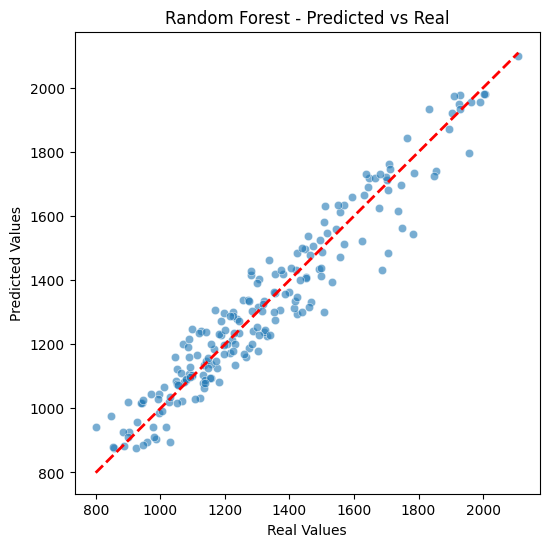

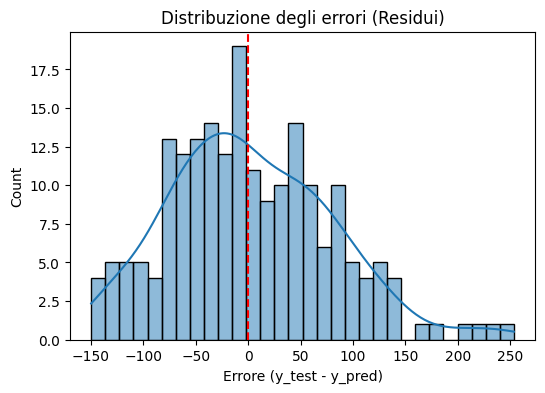

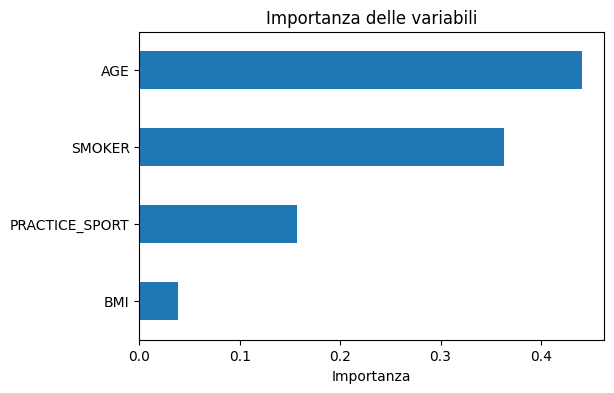

MAE = 61.96
RMSE = 77.44
R² = 0.927


In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Valori predetti ===
y_pred = rf.predict(X_test)

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
# Draw the perfect prediction line (y=x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest - Predicted vs Real")
plt.savefig("../../assets/regression.png",dpi=300)
plt.show()

# === 2️⃣ Distribuzione residui ===
residui = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residui, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribuzione degli errori (Residui)")
plt.xlabel("Errore (y_test - y_pred)")
plt.show()

# === 3️⃣ Importanza delle variabili ===
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(6,4))
importances.plot(kind='barh')
plt.title("Importanza delle variabili")
plt.xlabel("Importanza")
plt.show()

# === 4️⃣ Metriche di performance ===
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R² = {r2:.3f}")


se la mia predizione è sotto, va bene perche si fa margine, se è sopra, devo calcolare quanto devo alzare il prezzo basandomi sui miei dati (predico con il modello, e calcolo real_price vs predicted_price, e in base a questo calcolo un fattore di aggiustamento del prezzo. => predicted_price - real_price)/real_price

Prezzo base medio: 1322.52 €
count    200.000000
mean      -0.185186
std       21.084666
min      -33.722301
25%      -16.317438
50%       -3.648499
75%       12.236419
max       58.657491
Name: adjustment_percent, dtype: float64


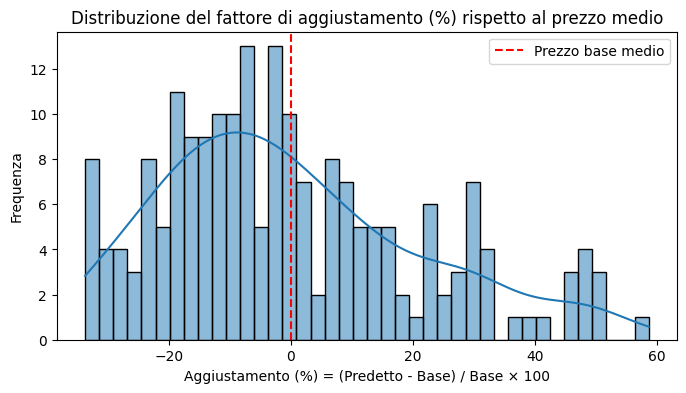

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# === Prezzo medio base (baseline) ===
base_price = y_test.mean()
print(f"Prezzo base medio: {base_price:.2f} €")

# === Calcolo del fattore di aggiustamento percentuale ===
predicted_price = y_pred
adjustment = ((predicted_price - base_price) / base_price) * 100

# === Creiamo un DataFrame per analisi ===
adjustment_df = pd.DataFrame({
    "predicted_price": predicted_price,
    "adjustment_percent": adjustment
})

# === Statistiche generali ===
print(adjustment_df["adjustment_percent"].describe())

# === Visualizziamo la distribuzione ===
plt.figure(figsize=(8,4))
sns.histplot(adjustment, bins=40, kde=True)
plt.axvline(0, color='red', linestyle='--', label='Prezzo base medio')
plt.title("Distribuzione del fattore di aggiustamento (%) rispetto al prezzo medio")
plt.xlabel("Aggiustamento (%) = (Predetto - Base) / Base × 100")
plt.ylabel("Frequenza")
plt.legend()
plt.show()

In [159]:
X_test.iloc[[0]]

,BMI,AGE,SMOKER,PRACTICE_SPORT
521,28.460037,42,0,0


In [160]:
# === Valori predetti ===
y_pred_1 = rf.predict(X_test.iloc[[10]])
y_pred_1

array([1487.86876729])

In [161]:
base_price = y_train.mean()

In [162]:
# === Calcolo del fattore di aggiustamento percentuale ===
difference = y_pred_1 - base_price
if difference > 0:
    adjustment = ((y_pred_1 - base_price) / base_price) * 100
else:
    adjustment = 0

# format dorrectly the percentage to 2 points
print(f"The adjustment in percentage is: {adjustment[0]:.2f}%")

The adjustment in percentage is: 12.34%


In [83]:
import requests

# URL dell'endpoint
url = "http://localhost:8000/predict-adjustment"

payload_1 = {
    "eta": 28,
    "bmi": 23.5,
    "fumo": 0,
    "sport": 1
}

try:
    response = requests.post(url, json=payload_1)
    print(f"Status Code: {response.status_code}")
    print("Response JSON:")
    result = response.json()
    print(f"  Prezzo predetto: €{result['prezzo_predetto']}")
    print(f"  Prezzo base: €{result['prezzo_base']}")
    print(f"  Aggiustamento: {result['aggiustamento_percentuale']}% (€{result['aggiustamento_euro']})")
except requests.exceptions.RequestException as e:
    print(f"❌ Request failed: {e}")

Status Code: 200
Response JSON:
  Prezzo predetto: €241.23
  Prezzo base: €564.33
  Aggiustamento: 0.0% (€-323.1)


### Modello per reasoning non so se lo usiamo

In [147]:
import pandas as pd

rules_df = pd.read_csv("../../assets/learned_rules.csv")
print(rules_df.head())
print(len(rules_df))

   Unnamed: 0  BMI  AGE  SMOKER  PRACTICE_SPORT                    DECISION  \
0           0   22   25   False            True                    accepted   
1           1   30   45    True           False  accepted with extra charge   
2           2   27   35   False           False                    accepted   
3           3   35   55    True           False  accepted with extra charge   
4           4   19   20   False            True                    accepted   

                                             COMMENT  
0  nothing special, young healthy non-smoker prac...  
1   smoker with moderate BMI, increased premium risk  
2                  healthy BMI, non-smoker, age ≤ 60  
3                         smoker with overweight BMI  
4              nothing special, fit young individual  
4427


In [163]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import os
import joblib

# Try to load rules.csv if available
csv_path = "../../assets/learned_rules.csv"
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    source = "loaded from rules.csv"
else:
    raise FileNotFoundError("rules.csv not found at the specified path.")

# Show a small slice of the dataset
display_df = df.head(12).copy()

# Encode features
X = df[["BMI", "AGE", "SMOKER", "PRACTICE_SPORT"]].copy()

# Convert booleans to int if present
for col in ["SMOKER", "PRACTICE_SPORT"]:
    if X[col].dtype == bool:
        X[col] = X[col].astype(int)
    else:
        X[col] = X[col].map({True: 1, False: 0, "True": 1, "False": 0}).fillna(0).astype(int)

# Encode target variable
y = df["DECISION"].astype(str)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=0)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate performance
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

# Detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optional: feature importance via permutation
perm_importance = permutation_importance(clf, X_test, y_test, random_state=0)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("\nPermutation Feature Importances:")
print(feature_importance)

# Save model and encoder (optional)
joblib.dump(clf, "../../assets/predictor_decision.joblib")
joblib.dump(le, "../../assets/label_encoder.joblib")


Accuracy: 0.999

Classification Report:
                                 precision    recall  f1-score   support

                       accepted       1.00      1.00      1.00       175
     accepted with extra charge       1.00      1.00      1.00       580
need for additional information       1.00      0.94      0.97        18
                       rejected       1.00      1.00      1.00       113

                       accuracy                           1.00       886
                      macro avg       1.00      0.99      0.99       886
                   weighted avg       1.00      1.00      1.00       886


Confusion Matrix:
[[175   0   0   0]
 [  0 580   0   0]
 [  0   1  17   0]
 [  0   0   0 113]]

Permutation Feature Importances:
          Feature  Importance
0             BMI    0.405192
2          SMOKER    0.303612
1             AGE    0.113995
3  PRACTICE_SPORT    0.033409


['../../assets/label_encoder.joblib']

In [107]:
shap_values.shape
# # sample, feature, classes

(1, 4, 4)

In [164]:
# Questo è l'array delle tue classi, NELL'ORDINE corretto
class_labels = clf.classes_

# Stampa per verifica (dovrebbe mostrarti i label numerici, es: [0, 1, 2, 3])
print(f"Classi del modello (numeriche): {class_labels}")

# Se vuoi le etichette TESTUALI nello stesso ordine, 
# puoi usare l'attributo .classes_ del LabelEncoder
text_labels = le.classes_

# Stampa per verifica (dovrebbe mostrarti i label testuali)
print(f"Etichette del LabelEncoder (testo): {text_labels}")


Classi del modello (numeriche): [0 1 2 3]
Etichette del LabelEncoder (testo): ['accepted' 'accepted with extra charge' 'need for additional information'
 'rejected']


In [165]:
test_index = 2 if len(df) > 2 else 0
test_sample = X.iloc[[test_index]]

# test sample should be BMI=32, AGE=40, SMOKER=True, PRACTICE_SPORT=False
test_sample = pd.DataFrame({
    "BMI": [28],
    "AGE": [51],
    "SMOKER": [1],
    "PRACTICE_SPORT": [1]
})

pred_proba = clf.predict_proba(test_sample)[0]
pred_label = clf.predict(test_sample)[0]
pred_decision = le.inverse_transform([pred_label])[0]
print("The predicted label is ", pred_decision)

# Try SHAP (optional)
shap_available = False
shap_results = None
try:
    import shap
    shap_available = True
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(test_sample)  # list per-class
    # For multiclass, compute absolute mean across classes to find top feature for prediction
    # Find index of predicted class

    pred_class = int(pred_label)
    # shap_values[pred_class] is array (1, n_features)
    sv = shap_values[0, :, pred_class].reshape(-1)
    shap_series = pd.Series(sv, index=X.columns).sort_values(key=np.abs, ascending=False)
    print(shap_series.to_string())
except Exception as e:
    shap_error = str(e)
    print(shap_error)


The predicted label is  accepted with extra charge
SMOKER            0.306940
BMI               0.045701
AGE              -0.014906
PRACTICE_SPORT    0.007866


In [166]:
list(df.COMMENT.head())

['nothing special, young healthy non-smoker practicing sport',
 'smoker with moderate BMI, increased premium risk',
 'healthy BMI, non-smoker, age ≤ 60',
 'smoker with overweight BMI',
 'nothing special, fit young individual']